In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time


import skimage.io as img_io
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.contrib import layers as ly

gpu_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95 , allow_growth=True) 
                             ,device_count={'GPU': 1})


logdir="InfoGAN-ver0"
print("file name : "+logdir+"\n")

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


file name : InfoGAN-ver0



In [2]:
data_root = "data"
train_path = os.path.join( data_root , "train" )
test_path = os.path.join( data_root , "test" )


## load image
training_img = []
for f in os.listdir(train_path):
    training_img.append( img_io.imread( os.path.join( train_path , f ) ) )

for f in os.listdir(test_path):
    training_img.append( img_io.imread( os.path.join( test_path , f ) ) )

    
training_img = np.array(training_img).astype("float")

print("Shape of training data :" , training_img.shape)

Shape of training data : (42621, 64, 64, 3)


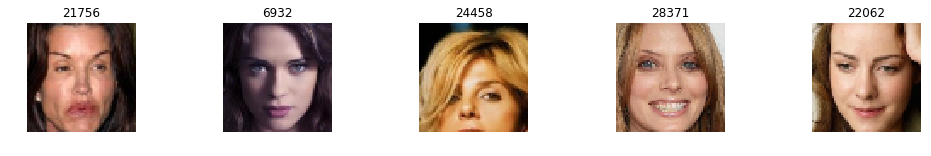

In [3]:
k = 5
idx = np.random.choice(42621, size=k)

fig = plt.figure(figsize=(3*k+2,2))
for i,img_name in enumerate( idx ):
    ax = fig.add_subplot( 1,k , i+1 )
    ax.imshow( training_img[img_name].astype("int") )
    ax.axis("off")
    
    ax.set_title(str(img_name))
plt.show()


In [4]:
processing_input = lambda x : (x/255-0.5)*2
inverse_processing = lambda x : (x/2+0.5)*255

In [5]:
train_data = processing_input(training_img)

(-0.5, 648.5, 63.5, -0.5)

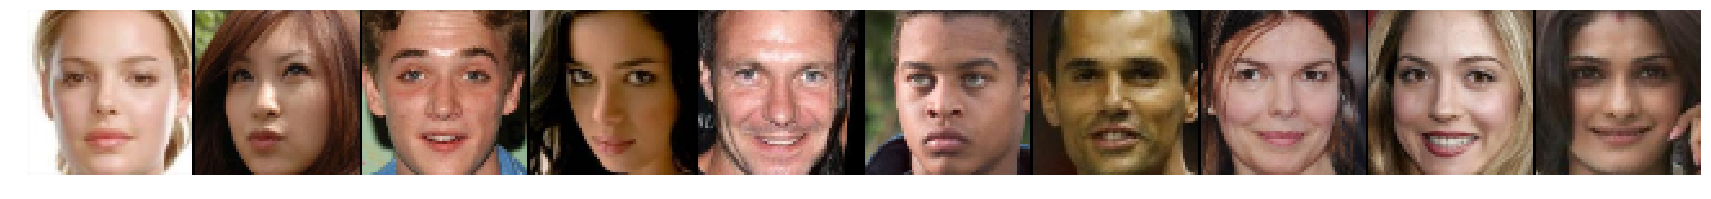

In [6]:
def concat_img(g , col=10):
    concat_all_img = []
    img_count = g.shape[0]
    row_padding = np.zeros(shape=[1 , g.shape[2]*col+col-1,3])
    col_padding = np.zeros(shape=[g.shape[1],1,3])
    for i in range(img_count//col):
        a = g[i*col]
        for j in range(1,col):
            a = np.concatenate( [ a , col_padding , g[ i*col+j ]  ] , axis=1  )
        concat_all_img.append(a)
        if i == (img_count//col-1):
            break
        concat_all_img.append(row_padding)
    return np.concatenate( concat_all_img , axis=0 )

test1 = training_img[0:10]
concat_test = concat_img( test1 ).astype("int")

plt.figure(figsize=(30,5))
plt.imshow(concat_test)
plt.axis("off")

## Build GAN

[Tutorial](https://github.com/jonbruner/generative-adversarial-networks/blob/master/gan-notebook.ipynb)  by Jon Bruner and Adit Deshpande
  
[Tips](https://github.com/soumith/ganhacks)

### ACGAN

    Structure:
        Generator -> Feature extractor |-> descriminator
        Real image---↗                 |-> classifier
        

In [7]:
def Feature_extractor( inputs , reuse_flag=None ):
    """
    Defined by GAN.
    The model is to descriminate real image or fake image.
    Design with ConvNet and add batch normalization.
    
    Args:
        inputs : a 4-D tensor , shape is [None,64,64,3]. Dtype must be float.
        reuse_flag : a boolean value. Notice that it should be true while training generative model
    
    return:
        2-D tensor : [None,13,13,128].
    """
    print("Build descriminator")
    x = ly.conv2d( inputs , 128 , kernel_size=[5,5] , stride=[2,2] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_1")
    x = ly.conv2d( x , 64 , kernel_size=[3,3] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_2" )
    x = ly.avg_pool2d( x , [3,3] , stride=[2,2] , padding="VALID" , scope="d_pool_w_1" ) 
    
    return x
    

In [8]:
def Descriminate( inputs , reuse_flag=None ):
    assert len(inputs.shape) == 4
    with tf.variable_scope("desc_var" , reuse=reuse_flag):
        x = ly.conv2d( inputs  , 64 , kernel_size=[3,3] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                      , reuse=reuse_flag , scope="d_conv_3_real_fake" )
        x = ly.conv2d( x , 32 , kernel_size=[3,3] , stride=[2,2] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                      , reuse=reuse_flag , scope="d_conv_4_real_fake" )
        x = ly.flatten( x )
        x = ly.fully_connected( x , 64 , activation_fn=tf.nn.leaky_relu , scope="d_fc_real_fake_1")
        x = ly.fully_connected( x , 32 , activation_fn=tf.nn.leaky_relu , scope="d_fc_real_fake_2")
        x = ly.fully_connected( x , 1 , activation_fn=None , scope="d_fc_real_fake_3")
    assert int(x.shape[-1]) == 1
    return x
        

In [9]:
def Classifier( inputs , reuse_flag=None , num_class=1 ):
    assert len(inputs.shape) == 4
    with tf.variable_scope("clf_var" , reuse=reuse_flag):
        x = ly.conv2d( inputs  , 64 , kernel_size=[3,3] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                      , reuse=reuse_flag , scope="d_conv_3_clf" )
        x = ly.conv2d( x , 32, kernel_size=[2,2] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                      , reuse=reuse_flag , scope="d_conv_4_clf" )
        x = ly.avg_pool2d(x , [3,3] , stride=[2,2] , scope="d_5_clf")
        x = ly.flatten(x)
        x = ly.fully_connected(x , 64 , scope="d_clf_1")
        x = ly.fully_connected(x , 32 , scope="d_clf_2")
        x = ly.fully_connected(x , num_class , activation_fn=None , scope="d_clf_3")
    assert int(x.shape[-1]) == num_class
    return x

In [82]:
def Mix_attr( attr_inputs , z_inputs ):
    """
    Mixed z_inputs with attr vector
    """
    with tf.variable_scope("embedding" , reuse=True):
        emb = tf.get_variable("attr")
    zero_vec = tf.zeros_like(emb[0:1,:])
    emb = tf.concat([zero_vec,emb] , axis=0)
    
    z = attr_inputs@emb 
    
#     z = tf.concat([z_inputs , z] , axis=-1)
#     z = ly.fully_connected( z , latent_dim*2 , activation_fn=tf.nn.leaky_relu , scope="g_mix_0"  )
    z = ly.fully_connected( z , latent_dim , activation_fn=tf.nn.tanh , scope="g_mix_1"  )/10.0
#     z = tf.concat([z , z_inputs] , axis=-1)
    z = tf.add( z , z_input )
    return z

In [83]:
def Generate( z ):
    """
    Defined by GAN.
    The model is to generate image to cheat descrinator.
    Design with Conv2DTranspose and add batch normalization.
    
    Args:
        inputs : a 2-D tensor , shape is [batch size , z_dim]. Dtype must be float.
                Notice : z_dim nust be multiple of 4
    
    return:
        4-D tensor : [batch size , 64 , 64 , 3].
    """
    bias_regular = ly.l2_regularizer(0.2)
    print("Build generator")
    ## z is 512
    x = tf.reshape(z , [-1,1,1,int(z.shape[1])])
    x = ly.conv2d( x , 2048 , [1,1] , stride=[1,1] , activation_fn=tf.nn.selu 
                  , biases_regularizer=bias_regular 
                  , scope="g_conv_0")
    x = tf.reshape( x , [ -1,2,2,2048//4 ] )
    x = ly.conv2d_transpose( x , 512 , [4,4] , stride=[2,2] , activation_fn=tf.nn.selu 
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_0")
    print(x.shape)
    ## 4x4x128
    x = ly.batch_norm( x , scope="g_bn_1")
    x = ly.conv2d_transpose( x , 256 , [4,4] , stride=[2,2] , activation_fn=tf.nn.selu
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_1")
    
#     print(x.shape)
    ## 4x4  why should kernel size be 6x6 not 5x5 ? 
    x = ly.conv2d_transpose( x , 128 , [5,5] , stride=[2,2] , activation_fn=tf.nn.selu
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_2")
    x = ly.batch_norm( x , scope="g_bn_2")
    
    x = ly.conv2d_transpose( x , 96 , [5,5] , stride=[2,2] , activation_fn=tf.nn.selu
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_3")
#     x = tf.add(x , x_1 )
    print(x.shape)
    x = ly.conv2d_transpose( x , 64 , [3,3] , stride=[2,2] , activation_fn=tf.nn.selu
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_4")
    x = ly.conv2d( x , 3 , [1,1] , stride=[1,1] , activation_fn=tf.nn.tanh
                            , biases_regularizer=bias_regular
                            , padding="SAME" , scope="g_5")
    print(x.shape)
    
    return x

In [84]:
tf.reset_default_graph()

In [85]:
InfoGAN_graph = tf.Graph()


print(logdir+"\n")
with InfoGAN_graph.as_default():
    latent_dim=128
    attr_latent_dim=32
    num_class=5
    with tf.name_scope("Input"):
        img = tf.placeholder( shape=[None,64,64,3] , dtype=tf.float32 , name="image")
        real_tag = tf.placeholder( shape=[None,1] , dtype=tf.float32 , name="real_label")

        z_input = tf.placeholder( shape=[None,latent_dim] , dtype=tf.float32 , name="latent_space")
        clf_tag = tf.placeholder( shape=[None,num_class] , dtype=tf.float32 , name="class" )
    
    with tf.variable_scope("embedding"):
        tf.get_variable("attr" , shape=[num_class-1,attr_latent_dim] , initializer=tf.truncated_normal_initializer())
    
    with tf.name_scope("Mix_z"):
        z = Mix_attr(clf_tag , z_input)
    
    with tf.name_scope("Generator"):
        g_img = Generate(z)
    
    with tf.name_scope("Feature_extractor"):
        d_feat = Feature_extractor( img )
        g_feat = Feature_extractor( g_img , reuse_flag=True )
    
    with tf.name_scope("Descriminator"):
        d_score = tf.nn.sigmoid(Descriminate(d_feat))
        g_score = tf.nn.sigmoid(Descriminate(g_feat , reuse_flag=True))
    
    with tf.name_scope("Classifier"):
        d_clf = tf.nn.softmax(Classifier(d_feat , num_class=num_class))
        g_clf = tf.nn.softmax(Classifier(g_feat , reuse_flag=True , num_class=num_class))
    
    with tf.name_scope("Loss"):
        with tf.name_scope("desc"):
            d_loss_real = tf.reduce_mean(-( real_tag*tf.log( tf.clip_by_value(d_score,1e-10,1) ) ))
            d_loss_fake = tf.reduce_mean(-(1-real_tag)*tf.log( tf.clip_by_value(1-d_score,1e-10,1) ) )
            d_loss = d_loss_real+d_loss_fake
            g_loss = tf.reduce_mean(-tf.log( tf.clip_by_value(g_score,1e-10,1) ) )
        with tf.name_scope("clf"):
            d_clf_loss = tf.reduce_mean( -tf.reduce_sum( clf_tag*tf.log(tf.clip_by_value(d_clf,1e-10,1)) , axis=-1 ))
            g_clf_loss = tf.reduce_mean( -tf.reduce_sum( clf_tag*tf.log(tf.clip_by_value(g_clf,1e-10,1)) , axis=-1 ))
#             d_clf_loss = tf.reduce_mean( -(clf_tag*tf.log(tf.clip_by_value(d_clf,1e-10,1)))\
#                                         -(1-clf_tag)*tf.log( tf.clip_by_value(1-d_clf,1e-10,1)) )
#             g_clf_loss = tf.reduce_mean( -(clf_tag*tf.log(tf.clip_by_value(g_clf,1e-10,1)))\
#                                         -(1-clf_tag)*tf.log( tf.clip_by_value(1-g_clf,1e-10,1)) )
    
    with tf.name_scope("Acc"):
        acc = tf.cast(tf.equal(tf.cast(tf.greater( d_score , 0.5 ) , tf.float32 ), real_tag ) , tf.float32)
        acc = tf.reduce_mean(acc)
        
        acc_clf = tf.cast( tf.equal( tf.argmax(g_clf , axis=-1), tf.argmax(clf_tag , axis=-1) ) , tf.float32)
        acc_clf = tf.reduce_mean(acc_clf)
                

    tvars = tf.trainable_variables()

    for v in tvars:
        if "d_" in v.name:
            if "real_fake" in v.name:
                tf.add_to_collection( "desc" , v )
            elif "clf" in v.name:
                tf.add_to_collection( "clf" , v )
            else:
                tf.add_to_collection( "desc" , v )
#                 tf.add_to_collection( "clf" , v )
        elif "g_" in v.name:
            tf.add_to_collection( "gene" , v )

    print("Descrimimator : " , [v.name for v in tf.get_collection("desc")])
    print()
    print("Generator : " , [v.name for v in tf.get_collection("gene")])
    
    with tf.name_scope("train_strategy"):
        # Train the discriminator
        d_trainer = tf.train.RMSPropOptimizer(1e-4).minimize(d_loss, var_list=tf.get_collection("desc"))
        d_info_trainer = tf.train.RMSPropOptimizer(1e-4).minimize(g_clf_loss, var_list=tf.get_collection("clf"))

        # Train the generator
        g_trainer = tf.train.AdamOptimizer(5e-5).minimize(g_loss+g_clf_loss, var_list=tf.get_collection("gene"))

    # Initialize
    init = tf.global_variables_initializer()
    
    # From this point forward, reuse variables
#     tf.get_variable_scope().reuse_variables()
#     with tf.name_scope("image_generate"):
#         images_for_tensorboard = Generate(z_input)
#     tf.summary.image('Generated_images', images_for_tensorboard, 5)
    
    g_summary = tf.summary.merge([tf.summary.scalar('generator/loss', g_loss)
                                  ,tf.summary.scalar('generator/clf_loss', g_clf_loss)
                                  ,tf.summary.scalar('generator/clf_acc', acc_clf)])
    
    d_summry = tf.summary.merge([tf.summary.scalar('descriminator/loss', d_loss)
                                 ,tf.summary.scalar('descriminator/acc', acc)])
    
#     merged = tf.summary.merge_all()
    writer_g = tf.summary.FileWriter("tb_logs/{}".format(logdir) , graph=InfoGAN_graph)
    writer_real = tf.summary.FileWriter("tb_logs/{}/real".format(logdir))
    writer_fake = tf.summary.FileWriter("tb_logs/{}/fake".format(logdir))
    
    saver = tf.train.Saver(var_list=tf.get_collection("gene") , max_to_keep=10)
    

InfoGAN-ver0

Build generator
(?, 4, 4, 512)
(?, 32, 32, 96)
(?, 64, 64, 3)
Build descriminator
Build descriminator
Descrimimator :  ['d_conv_1/weights:0', 'd_conv_1/biases:0', 'd_conv_2/weights:0', 'd_conv_2/biases:0', 'desc_var/d_conv_3_real_fake/weights:0', 'desc_var/d_conv_3_real_fake/biases:0', 'desc_var/d_conv_4_real_fake/weights:0', 'desc_var/d_conv_4_real_fake/biases:0', 'desc_var/d_fc_real_fake_1/weights:0', 'desc_var/d_fc_real_fake_1/biases:0', 'desc_var/d_fc_real_fake_2/weights:0', 'desc_var/d_fc_real_fake_2/biases:0', 'desc_var/d_fc_real_fake_3/weights:0', 'desc_var/d_fc_real_fake_3/biases:0']

Generator :  ['g_mix_1/weights:0', 'g_mix_1/biases:0', 'g_conv_0/weights:0', 'g_conv_0/biases:0', 'g_0/weights:0', 'g_0/biases:0', 'g_bn_1/beta:0', 'g_1/weights:0', 'g_1/biases:0', 'g_2/weights:0', 'g_2/biases:0', 'g_bn_2/beta:0', 'g_3/weights:0', 'g_3/biases:0', 'g_4/weights:0', 'g_4/biases:0', 'g_5/weights:0', 'g_5/biases:0']


In [86]:
with InfoGAN_graph.as_default():
    my_var = tf.trainable_variables("embed")

In [87]:
my_var

[<tf.Variable 'embedding/attr:0' shape=(4, 32) dtype=float32_ref>]

### Training

while training descriminator 3 times , training generator 1 time.

In [88]:
sess = tf.Session( graph=InfoGAN_graph , config=gpu_opt )
sess.run(init)

In [89]:
def shuffle_data():
    global train_data , r_index
    
    np.random.shuffle(r_index)
    return train_data[r_index]


In [90]:
pr_img_path = "tmp/{}".format(logdir)
if not os.path.exists(pr_img_path):
    os.mkdir(pr_img_path)
print("Image path is ", pr_img_path)

test_z = np.random.randn(10,latent_dim)
test_attr = []

for i in range(num_class):
    tmp_a = np.zeros(shape=[10,num_class])
    tmp_a[:,i] += 1
    test_attr.append(tmp_a)
    del tmp_a

np.save( os.path.join( pr_img_path , "z_vector.npy" ) , test_z )

def print_generate_img(s):
    g = sess.run( g_img , feed_dict={z_input:test_z , clf_tag:test_attr[0]} )
    for i in range(1,num_class):
        tmp_g = sess.run( g_img , feed_dict={z_input:test_z , clf_tag:test_attr[i]} )
        g = np.concatenate( [g , tmp_g] , axis=0 )
    g = inverse_processing(g)
    g = concat_img(g).astype("int")
    
    plt.figure(figsize=(25,5)) 
    plt.imshow(g)
    plt.axis("off")
    path = os.path.join( pr_img_path , "{0:0>6}_iter.png".format(s) )
    plt.savefig(path)
    plt.show()

Image path is  tmp/InfoGAN-ver0


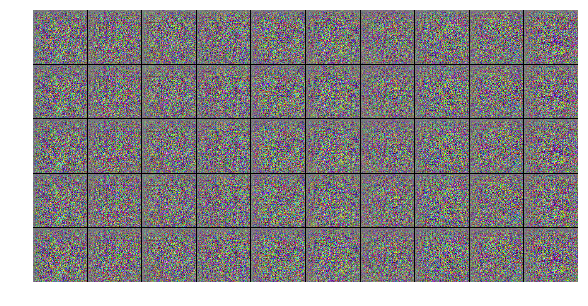

In [91]:
print_generate_img("test")

In [92]:
model_path = "model_para/{}".format(logdir)
if not os.path.exists(model_path):
    os.mkdir(model_path)
print("model path is ",model_path)
def save_model(s):
    p = os.path.join(model_path , "generator_"+str(s+1)+".ckpt")
    saver.save(sess , p)

model path is  model_para/InfoGAN-ver0


In [93]:
def sample_dum(z):
    a = np.argmax(z,axis=-1)
    z = np.zeros_like(z)
    z[a]+=1
    return z


In [94]:
n_step = 100000
n_batch = 200
d_training_count = 1

r_index = np.arange(train_data.shape[0])
data_x = train_data

start=0
information_printer = "Step {0:d} loss:{1:.4f} fake:{2:.4f} real:{3:.4f} acc:{4:.3f} acc_clf:{5:.3f} f/r:{6:2.3f}"

for s in range(n_step):
    if (start+n_batch) > train_data.shape[0]:
        start = 0
        data_x = shuffle_data()
    for _ in range(d_training_count):
        batch_z = np.random.randn(n_batch,latent_dim)
        batch_z_attr = np.apply_along_axis(sample_dum , axis=1 , arr=np.random.uniform(size=[200,num_class]))
        batch_g_img = sess.run( g_img , feed_dict={z_input:batch_z,clf_tag:batch_z_attr} )

        batch_x = np.concatenate([data_x[start:start+n_batch] , batch_g_img],axis=0)
        batch_y = np.concatenate([np.ones(shape=[n_batch,1]) , np.zeros(shape=[n_batch,1])] ,axis=0 )

        _ , l , accuracy  = sess.run([d_trainer , d_loss , acc ]
                                     ,feed_dict={ img:batch_x , real_tag:batch_y})
    
    _ , accuracy_clf = sess.run( [d_info_trainer , acc_clf ] , feed_dict={z_input:batch_z , clf_tag:batch_z_attr} )
    
    _ , fake = sess.run( [d_summry , d_loss] 
                        ,feed_dict={ img:batch_x[n_batch:] , real_tag:batch_y[n_batch:] , clf_tag:batch_z_attr})
    writer_fake.add_summary(_ , s+1)
    _ , real = sess.run( [d_summry , d_loss] 
                        ,feed_dict={ img:batch_x[0:n_batch] , real_tag:batch_y[0:n_batch]})
    writer_real.add_summary(_ , s+1)
    
    
    summary , _ = sess.run([g_summary,g_trainer],feed_dict={z_input:batch_z,clf_tag:batch_z_attr})
    writer_g.add_summary(summary,s+1)
    
    print( information_printer.format(s+1 , l , fake , real , accuracy , accuracy_clf , fake/real ) , end="\r" )
    if ( (s+1)%5000 ) == 0:
        print( information_printer.format(s+1 , l , fake , real , accuracy , accuracy_clf , fake/real ) , end="\n" )
        print_generate_img(s+1)
        save_model(s)
    start += n_batch

KeyboardInterrupt: 

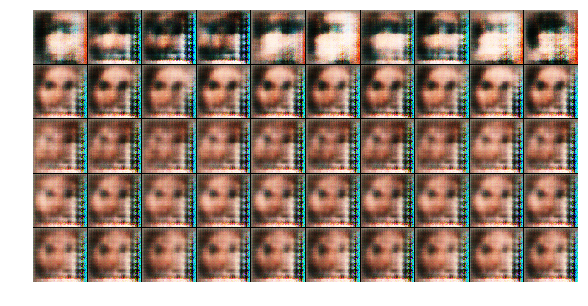

In [81]:
g = sess.run( g_img , feed_dict={z_input:np.random.randn(10,latent_dim) , clf_tag:test_attr[0]} )
for i in range(1,num_class):
    tmp_g = sess.run( g_img , feed_dict={z_input:test_z , clf_tag:test_attr[i]} )
    g = np.concatenate( [g , tmp_g] , axis=0 )
g = inverse_processing(g)
g = concat_img(g).astype("int")

plt.figure(figsize=(25,5)) 
plt.imshow(g)
plt.axis("off")
# path = os.path.join( pr_img_path , "{0:0>6}_iter.png".format(s) )
# plt.savefig(path)
plt.show()